<a href="https://colab.research.google.com/github/grkidwell/max_charge_current/blob/master/max_charge_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Battery Charger Design Optimization

###Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

plt.style.use('seaborn')

In [2]:
!git clone https://github.com/grkidwell/max_charge_current.git

fatal: destination path 'max_charge_current' already exists and is not an empty directory.


###Functions and Classes

In [0]:
class Battery:
  
  def __init__(self,nstack=2,J=50, soc=1):
    
    self.nstack=nstack    # 2S, 3S, 4S
    self.capacity=J       # Watt*hrs
    self.soc=soc          # state of charge.  0.01 to 1  (1% to 100%)
    
    self.vcellmin=3.0
    self.vcellnom=3.7
    self.vcellmax=4.2
    
    self.res=0.2  # Rbattery.  Path resistance, in Ohms, between the battery and charger output. Includes cell chemistry + busbar+connectors+cable+beads+pcb+BFET
    
    self.vmin=self.nstack*self.vcellmin
    self.vnom=self.nstack*self.vcellnom
    self.vmax=self.nstack*self.vcellmax
    
    self.crate=self.capacity/self.vnom
    
  #def voltage(self):
    state=self.soc   
    k=[3.49,1.429,6.101e-3,2.502]   #coefficients from Mathcad curve fit.
    vcell=k[0]+k[1]*np.exp(-k[3]*(1-state))-k[2]/(state+.001)
    
    self.voltage=max(self.vmin,min(self.vmax, self.nstack*vcell))  #battery voltage has upper and lower clamp
    
 
class Adaptor:
  
  def __init__(self, power=60, voltage=20):
  
    Aclim_tol  = 0.05
    
    
    self.power=power*(1-Aclim_tol)
    self.voltage=voltage
    
    self.ilim=self.power*(1-Aclim_tol)/voltage

    
    
    
class Charger:
  
  def __init__(self, adaptor, battery, psystem=0, imax=8.5):  #adaptor and battery are objects
  
      Efficiency = 0.95
      self.pmax=adaptor.power*Efficiency
      self.imax=imax
      self.vsys_mmp=self.pmax/imax   #vsys at max rated output current of charger.  digital vcore controller will monitor
      self.psys=psystem
    
      self.rbat=battery.res
      self.vsysmax=battery.vmax
      self.vsysmin=battery.vmin     
      self.vbat=battery.voltage
    
      
      self.ichargemax=0.8*battery.crate       #charging current limited by battery and charger setting
      
      self.VRhot = False
      
      # to do: might try setting these up as loops/states
      # to do: set up battery discharge state
      
      if self.psys > self.pmax:     #adaptor loop in control
        self.psys = self.pmax
        self.VRhot = True
        
      '''
      (1) Derive quadratic equation for Vsys at max output power

      Vsys = Vbat + icharge*Rbat
           = Vbat + (iout-isys)*Rbat
           = Vbat + (Pmax/Vsys - Psys/Vsys)*Rbat
           = Vbat + (Pmax-Psys)/Vsys*Rbat
           
      Vsys^2 - Vbat*Vsys - (Pmax-Psys)Rbat = 0
      
      (2) Derive quadratic equation for Vsys at max output current
      
      Vsys = Vbat + icharge*Rbat
           = Vbat + (imax- Psys/Vsys)*Rbat
           = Vbat + imax*Rbat - Psys*Rbat/Vsys
           
      Vsys^2 - (Vbat+imax*Rbat)Vsys + Psys*Rbat = 0

      '''   

      quadcoeff1 = [1, -self.vbat, -(self.pmax-self.psys)*self.rbat]
      quadcoeff2 = [1, -(self.vbat+self.imax*self.rbat), self.psys*self.rbat]
      
      vsys1 = max(np.roots(quadcoeff1))
      vsys2 = max(np.roots(quadcoeff2))
      
      if vsys1 > self.vsys_mmp:    #assume max adaptor power until either vsys or icharge is clamped
        vsys_a = vsys1
        
      else:                # vcore to throttle when vsys drops below level which would result in excessive charger current
        vsys_a = vsys2
        self.VRhot = True
        
      vsys_a = min(self.vsysmax, vsys_a)    #voltage loop in control
        
      icharge_a = (vsys_a - self.vbat)/self.rbat
        
      self.icharge = min(self.imax,self.ichargemax,icharge_a)
      self.vsys = self.vbat + self.icharge*self.rbat
      
      self.pout = self.vsys*self.icharge + self.psys
      self.iout = self.pout/self.vsys
 
     
  

    

In [4]:
7.2*8.5

61.2

###Description


> The purpose of this model 

>Battery charger size can be reduced by clamping the maximum output current.   
> The adaptor's full power can only be utilized when the battery voltage has reached Vbattmin  
> Full adaptor power is acheived when the system voltage is high enough so that


> We know that for a given adaptor power, the maximum charging current will be inversely proportional to the minimum system voltage,   
>>>$Icharge_{max}={Padaptor\over Vsystem_{min}}$ &emsp; &emsp; &emsp; (1)


In [0]:
adaptor60=Adaptor(60,20)

battery2S_depleted=Battery(2,50,soc=.01)
battery2S_halfcharge=Battery(2,50,soc=0.5)
battery2S_full=Battery(2,50,soc=1)

battery2S=[battery2S_depleted,
           battery2S_halfcharge,
           battery2S_full]

In [6]:
Battery(2,50,soc=.005).voltage

6.0

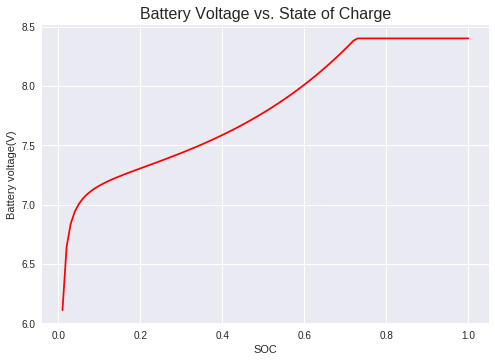

In [7]:
socvar = np.arange(.01,1.01,.01)
batlist = []
for i in socvar:
  batlist.append(Battery(2,50,soc=i).voltage) 
plt.plot(socvar,batlist,color='r')
plt.xlabel("SOC")
plt.ylabel("Battery voltage(V)")
plt.title("Battery Voltage vs. State of Charge" , fontsize=16)
plt.show()

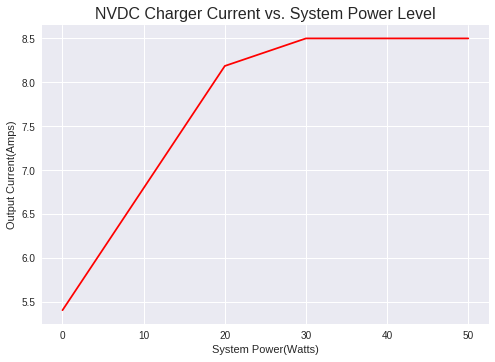

In [8]:

soclist = [0.01, 0.5, 1.0]
syspwr = np.arange(0,60,10)
chargercurrent = []
for p in syspwr:
  chargercurrent.append(Charger(Adaptor(90,20),Battery(2,50,soc=0.01),psystem=p, imax=8.5).iout) 
plt.plot(syspwr,chargercurrent,color='r')
plt.xlabel("System Power(Watts)")
plt.ylabel("Output Current(Amps)")
plt.title("NVDC Charger Current vs. System Power Level" , fontsize=16)
plt.show()




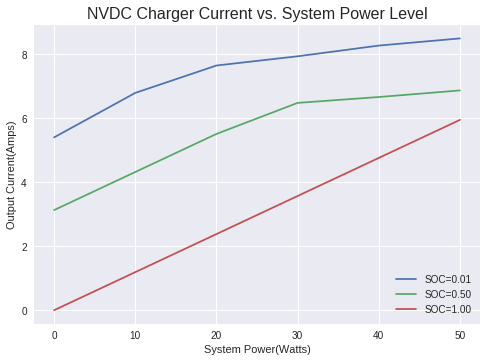

In [9]:

soclist = [0.01, 0.5, 1.0]
syspwr = np.arange(0,60,10)

for s in soclist:
  chargercurrent = []
  for p in syspwr:
    chargercurrent.append(Charger(Adaptor(60,20),Battery(2,50,soc=s),psystem=p, imax=8.5).iout) 
  plt.plot(syspwr,chargercurrent,label="SOC=%3.2f" % (s))
plt.xlabel("System Power(Watts)")
plt.ylabel("Output Current(Amps)")
plt.title("NVDC Charger Current vs. System Power Level" , fontsize=16)
plt.legend(ncol=1, loc='lower right')
plt.show()

In [10]:
xvar=np.arange(battery2S.vmin//1,(battery2S.vmax+1.5)//1,1)
yvar=Padaptor/xvar
plt.plot(xvar,yvar)
plt.xlim(left=np.min(xvar), right=np.max(xvar))
#plt.ylim(bottom=0,top=12)
plt.ylabel("charging current(A)")
plt.xlabel("system voltage(V)")
plt.title("Charge Current vs. System Voltage at %2.0fW Adaptor Power" % (Padaptor), fontsize=16)
#plt.legend(ncol=2, loc='lower left')
plt.show()

AttributeError: ignored

In [0]:
np.min(xvar)

> When the NB is off, all of the adaptor power is directed toward charging the battery and charger current is limited by the EC

> When the NB is on, the EC may need to throttle the system to keep the charger current within design specs.   


In [0]:
#@title
Image('max_charge_current/circuit_diagram.png', height=400,width=600)

> We know that for a given power adaptor, the maximum charge current will be inversely proportional to the minimum system voltage,   
>>>$Icharge_{max}={Padaptor\over Vsystem_{min}}$ &emsp; &emsp; &emsp; (1)



###When charging a battery during constant current mode, the resistance between the charger output and the battery  
###elevates the output voltage of charger above the battery voltage by a voltage proportional to the charge current
$(1) Vsystem = Icharge*Rbattery + Vbattery$
###Also, for a given power level, the system voltage will be inversely proportional to the charge current, so as the current decreases
###the charge output (or system) voltage will increase
$(2) Vsystem = Padaptor/Icharge$

###The intersection point of these 2 equations provides the solution of the  system voltage and charge current at maximum adaptor power

###Parameters

In [0]:
#Rbattery   = 0.2    # Rpcb + Rcable + Rbattery
#Padaptor   = 60     # Full adaptor power.   Will be derated by aclim tolerance and charger efficiency
#Vbatmin    = 7.4   # mimimum battery voltage where full power can be extracted from the adaptor.  This will be set by the EC



###Results

In [0]:
#@title
#Padap_actual = Padaptor*Efficiency*(1-Aclim_tol)
Imax = quadsolver(battery2S.res,battery2S.vmin,Padaptor)
voutmin=Padaptor/Imax

print("For %3.0fW Aadaptor, %1.0fS Battery" % (Padaptor,battery2S.nstack))
print("")
print("Max charge current = %3.1fA" % (Imax))
print("Charger output voltage = %3.1fV" % (voutmin))
print("Conduction loss = %3.1fW" % (battery2S.res*Imax**2))


### Graphs

In [0]:
#@title
i=np.arange(2,10,1)
vsys_2S=Vbatmin*2/3+i*Rbattery
vsys_3S=Vbatmin+i*Rbattery
vsys_4S=Vbatmin*4/3+i*Rbattery
vsys_90=Padaptor/i*Efficiency*(1-Aclim_tol)
vsys_65=65/i*Efficiency*(1-Aclim_tol)
vsys_45=45/i*Efficiency*(1-Aclim_tol)

plt.plot(i, vsys_2S, label="2S")
plt.plot(i, vsys_3S, label="3S")
plt.plot(i, vsys_4S, label="4S")
plt.plot(i, vsys_90, label="90W", linestyle='dashed')
plt.plot(i, vsys_65, label="65W", linestyle='dashed')
plt.plot(i, vsys_45, label="45W", linestyle='dashed')
plt.plot()

plt.xlim(left=2, right=9)
plt.ylim(bottom=2,top=20)

plt.text(5,18,'(1) Vsystem = Rbattery x Icharge + Vbattery ')
plt.text(5,4,'(2) Vsystem = Padaptor/Icharge ')

plt.xlabel("charging current(A)")
plt.ylabel("system voltage(V)")
plt.title("System Voltage vs. Charge Current at Max Adaptor Power", fontsize=16)
plt.legend(ncol=2, loc='lower left')
plt.show()